## Submitted by
### Anurag Nagarkoti (239426), Wahab Haseeb Bhatti (239978), Suyash Gawandi (239716)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython.display as display
import PIL.Image

/Users/suyash/DKE/Semester5/IDL/mlvenv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


6


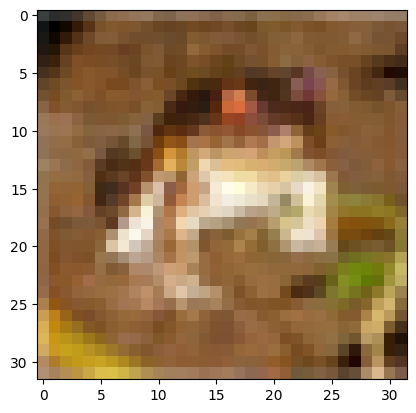

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# CIFAR labels for some reason are [N, 1] instead of just [N,] so we reshape them
train_labels = train_labels.reshape(-1).astype(np.int32)
test_labels = test_labels.reshape(-1).astype(np.int32)

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

print(train_labels[0])
plt.imshow(train_images[0])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
train_data = train_data.shuffle(buffer_size=60000).batch(128)

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)).batch(128)

In [3]:
def model():

    inputs = tf.keras.Input(shape=(32, 32, 3), name="img")

    x= tf.keras.layers.Conv2D(16, kernel_size=(3,3) , padding='same')(inputs) #outputs 32 x 32 x16
    x= tf.keras.layers.MaxPooling2D((2,2))(x)

    x= tf.keras.layers.Conv2D(16, kernel_size=(3,3) , padding='same')(x) #outputs 32 x 32 x16
    x= tf.keras.layers.MaxPooling2D((2,2))(x)

    x= tf.keras.layers.Conv2D(16, kernel_size=(3,3) , padding='same')(x) #outputs 32 x 32 x16

    x= tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs= tf.keras.layers.Dense(10)(x)

    model= tf.keras.Model(inputs, outputs, name='cnn')

    return model

In [4]:
cnn=model()
cnn

In [14]:
optimizer = tf.optimizers.legacy.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = tf.metrics.SparseCategoricalAccuracy()

# jit_compile can give a significant speed-up and improves memory usage
cnn.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric],
              jit_compile=True)

In [15]:
cnn.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
391/391 [==============================] - 6s 16ms/step - loss: 2.0066 - sparse_categorical_accuracy: 0.2511 - val_loss: 1.8631 - val_sparse_categorical_accuracy: 0.2948
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 1.8120 - sparse_categorical_accuracy: 0.3276 - val_loss: 1.7255 - val_sparse_categorical_accuracy: 0.3682
Epoch 3/10
391/391 [==============================] - 6s 16ms/step - loss: 1.7103 - sparse_categorical_accuracy: 0.3715 - val_loss: 1.6631 - val_sparse_categorical_accuracy: 0.3900
Epoch 4/10
391/391 [==============================] - 6s 16ms/step - loss: 1.6642 - sparse_categorical_accuracy: 0.3869 - val_loss: 1.6195 - val_sparse_categorical_accuracy: 0.4058
Epoch 5/10
391/391 [==============================] - 6s 16ms/step - loss: 1.6243 - sparse_categorical_accuracy: 0.4067 - val_loss: 1.6267 - val_sparse_categorical_accuracy: 0.4132
Epoch 6/10
391/391 [==============================] - 6s 16ms/step - loss: 1.5895 - sparse_cate

In [5]:
image=test_images[4]
print(test_labels[4])

6


In [6]:
test_images[0].shape

(32, 32, 3)

In [18]:
# FOLLOWING ARE THE SALIENCY MAPS
# just plot some example images
some_imgs = tf.convert_to_tensor(test_images[:4])


In [19]:
# as discussed in the class: mask out logits to keep only the ones we need!
# here: using the true labels
cnn(some_imgs) * tf.one_hot(test_labels.reshape(-1)[:1], depth=10)

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[-0.       ,  0.       ,  0.       ,  3.0047882, -0.       ,
         0.       ,  0.       , -0.       ,  0.       , -0.       ],
       [ 0.       ,  0.       , -0.       , -5.0709567, -0.       ,
        -0.       , -0.       , -0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       , -0.       , -2.1964133, -0.       ,
        -0.       , -0.       , -0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       , -0.       , -2.3687003, -0.       ,
        -0.       , -0.       , -0.       ,  0.       ,  0.       ]],
      dtype=float32)>

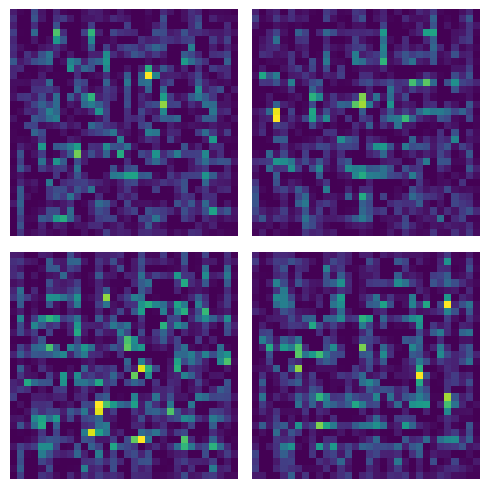

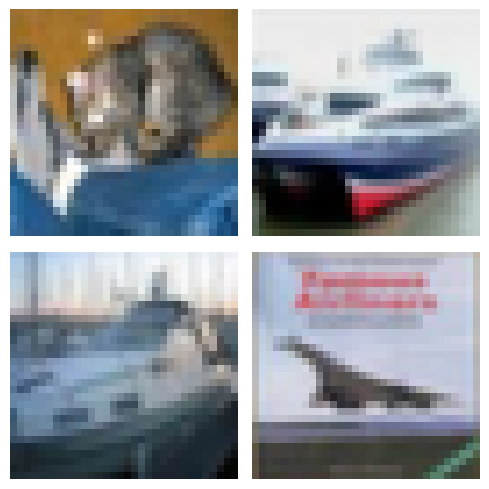

In [20]:
# basic saliency maps!

with tf.GradientTape() as tape:
    tape.watch(some_imgs)
    some_labels = tf.one_hot(test_labels[:1], depth=10)
    logits = cnn(some_imgs) * some_labels

grads = tape.gradient(logits, some_imgs).numpy()

# in practice, we often just care about positive contributions, so we remove negative values
grads_clip = np.where(grads >= 0, grads, 0)

# if we have multi-channel images, average channels
# no need to do this if you have e.g. MNIST as data
grads_mean = grads_clip.mean(axis=-1)

plt.figure(figsize=(5, 5))
for ind, img in enumerate(grads_mean):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
for ind, img in enumerate(some_imgs):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

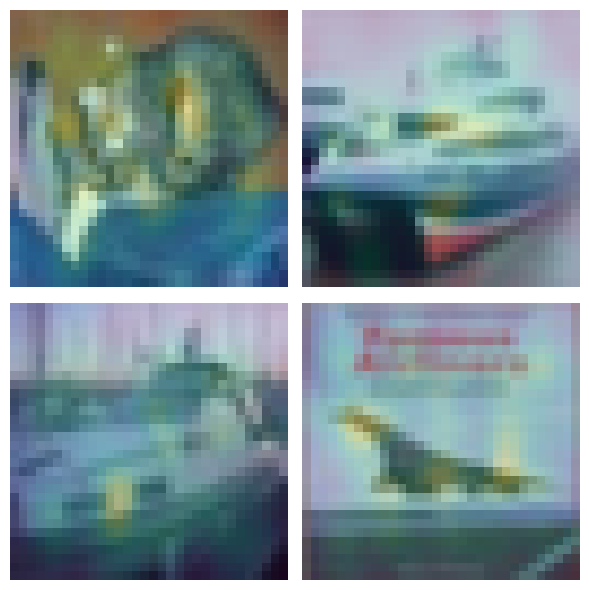

In [21]:
import scipy.ndimage

some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(6, 6))
for ind, (img, grad) in enumerate(zip(some_imgs, grads)):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    grad_clip = np.where(grad>0, grad, 0).mean(axis=-1)
    # in addition, slightly blur gradients to reduce noise
    grad_clip = scipy.ndimage.gaussian_filter(grad_clip, 2)

    plt.imshow(grad_clip, alpha=0.3)
    plt.axis("off")
    #plt.colorbar()
plt.tight_layout()
plt.show()

In [28]:
# def activation_maximization(some_imgs, some_labels, step_size):
#     with tf.GradientTape() as tape:
#         tape.watch(some_imgs)
#         some_labels = tf.one_hot(test_labels[:1], depth=10)
#         logits = cnn(some_imgs) * some_labels

#     grads = tape.gradient(logits, some_imgs).numpy()

#     grads /= tf.math.reduce_std(grads) + 1e-8 
        
#     # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
#     # You can update the image by directly adding the gradients (because they're the same shape!)
#     some_imgs = some_imgs + grads*step_size # Activation maximization
#     some_imgs = tf.clip_by_value(some_imgs, -1, 1)

#     plt.imshow(img)

In [172]:
def activation_maximization(img, steps=100, step_size=0.01):

    img=tf.reshape(tf.convert_to_tensor(img), [-1, 32,32, 3])
 
    loss = tf.constant(0.0)
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            # This needs gradients relative to `img`
            # `GradientTape` only watches `tf.Variable`s by default
            tape.watch(img)
            loss = cnn(img) 

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size # Activation maximization
        img = tf.clip_by_value(img, -1, 1)

    return loss, img, gradients    

In [173]:
def run_maximum_activation(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.

  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    img = activation_maximization(img, run_steps, tf.constant(step_size))
    
  return img

In [187]:
image=test_images[7]
result=run_maximum_activation(image,100, 0.001)

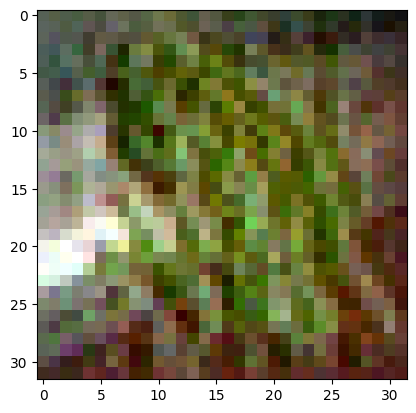

In [188]:
plt.imshow(tf.reshape(result[1], [32,32,3]).numpy())

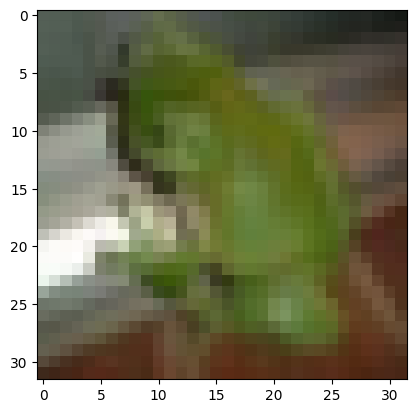

In [189]:
plt.imshow(image)